In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
data = pd.read_excel('dataset.xlsx')

In [78]:
df = data.copy()
df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Création des sous-ensembles(suite au EDA)

In [79]:
missing_rate = df.isna().sum() / df.shape[0]

In [80]:
blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate >0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate >0.75)])

In [81]:
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [82]:
df = df[key_columns + blood_columns + viral_columns]
df.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


# TrainTest - Nettoyage - Encodage

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [85]:
trainset['SARS-Cov-2 exam result'].value_counts()

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [86]:
testset['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

In [87]:
def encodage(df):
    code = {'positive':1,
      'negative':0,
      'detected':1,
      'not_detected':0
      }
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
    
    return df

In [88]:
def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)
    return df

In [89]:
def imputation(df):
    #df['is na'] = (df['Parainfluenza 3'].isna()) | (df['Leukocytes'].isna())
    #df.fillna(-999)
    df = df.dropna(axis=0)
    return df

In [90]:
def preprocessing(df):
    
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)
    
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result']
    
    print(y.value_counts())
    
    return X,y

In [91]:
X_train, y_train = preprocessing(trainset)

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64


In [92]:
X_test, y_test = preprocessing(testset)

0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


# Modélisation

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [94]:
#model_1 = RandomForestClassifier(random_state=0)
preprocessor= make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

In [95]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [96]:
dict_of_models = {'RandomForest':RandomForest, 
                  'AdaBoost': AdaBoost,
                  'SVM':SVM,
                  'KNN':KNN}

RandomForest
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111

(10, 4)
AdaBoost
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

(10, 4)
SVM
[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      

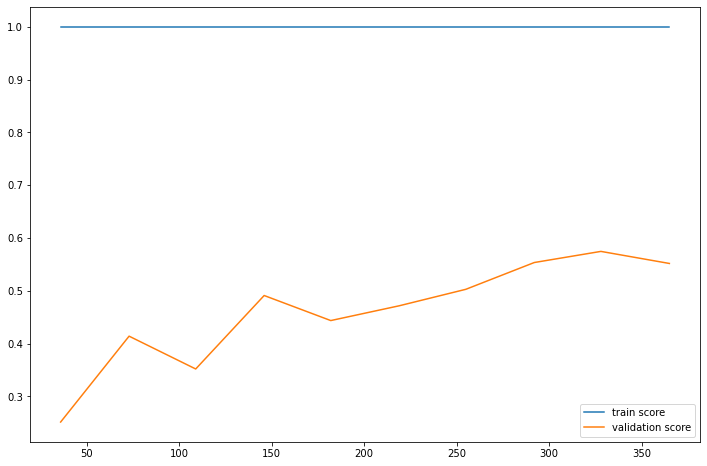

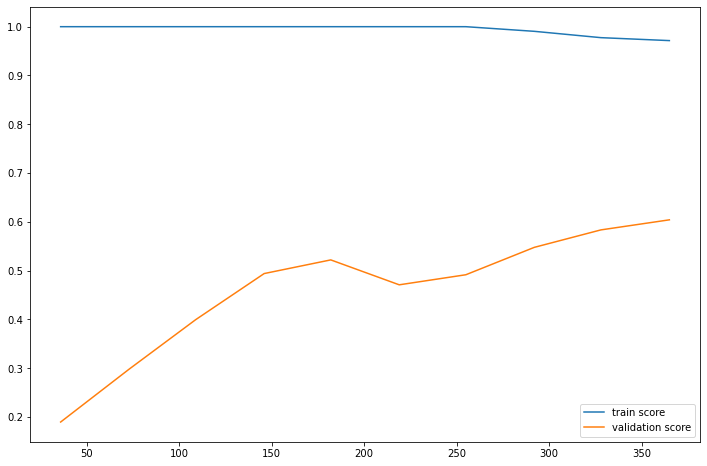

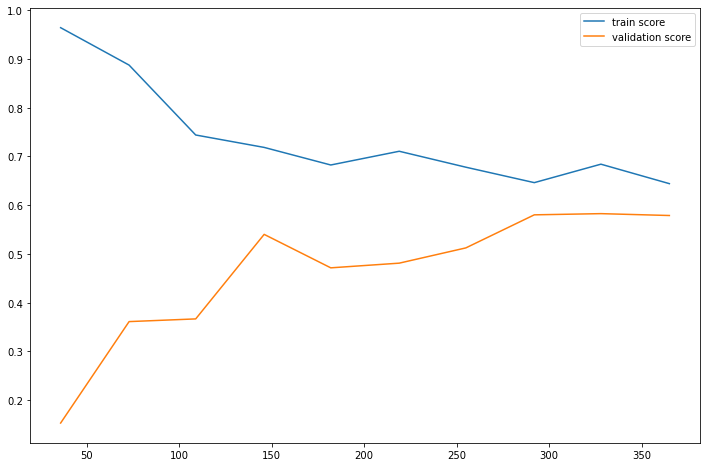

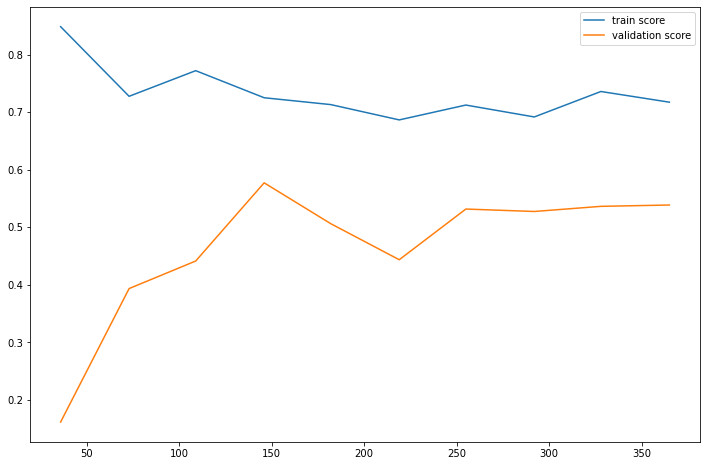

In [97]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

# Procédure d'évaluation

discover error proportion type1 & type2 in dataset( =>proportion FP & FN)

In [98]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve #discovering Overfitting/Underfitting ?

In [99]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                              train_sizes=np.linspace(0.1, 1, 10))
    print(train_score.shape)
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

[[92  3]
 [13  3]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        95
           1       0.50      0.19      0.27        16

    accuracy                           0.86       111
   macro avg       0.69      0.58      0.60       111
weighted avg       0.82      0.86      0.83       111

(10, 4)


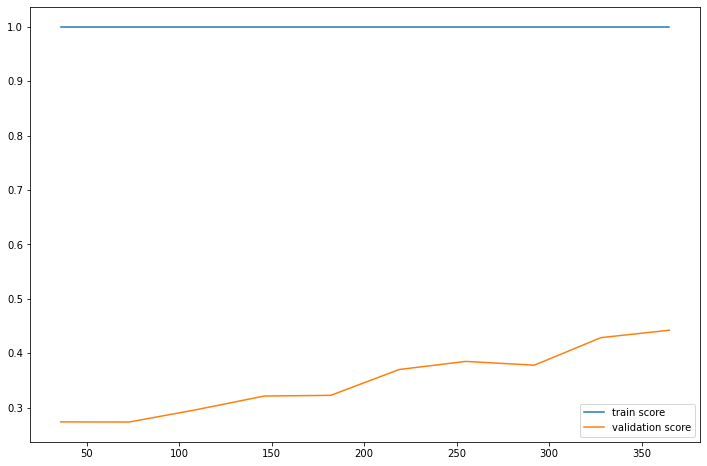

In [100]:
#evaluation(model_2)
evaluation(model_1)

<AxesSubplot:>

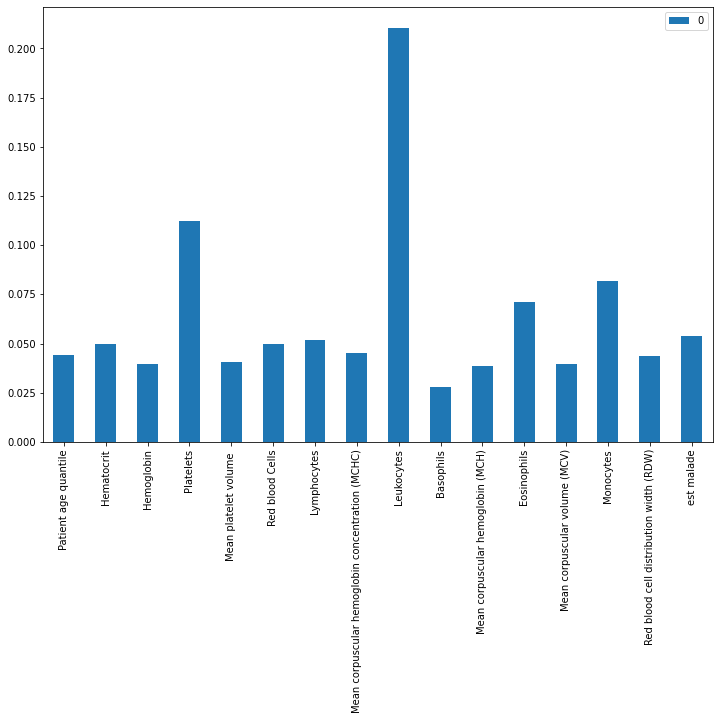

In [101]:
pd.DataFrame(model_1.feature_importances_, index=X_train.columns).plot.bar(figsize=(12, 8))

# Optimisation

In [111]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [112]:
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [116]:
hyper_params = {'svc__gamma':[1e-3, 1e-4],
                'svc__C':[1, 10, 100, 1000],
               'pipeline__polynomialfeatures__degree': [2, 3, 4],
               'pipeline__selectkbest__k': range(40, 60)}

In [117]:
grid = RandomizedSearchCV(SVM, hyper_params, scoring='recall', cv=4, 
                          n_iter=40)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'svc__gamma': 0.001, 'svc__C': 1000, 'pipeline__selectkbest__k': 59, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        95
           1       0.50      0.50      0.50        16

    accuracy                           0.86       111
   macro avg       0.71      0.71      0.71       111
weighted avg       0.86      0.86      0.86       111



[[87  8]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        95
           1       0.50      0.50      0.50        16

    accuracy                           0.86       111
   macro avg       0.71      0.71      0.71       111
weighted avg       0.86      0.86      0.86       111

(10, 4)


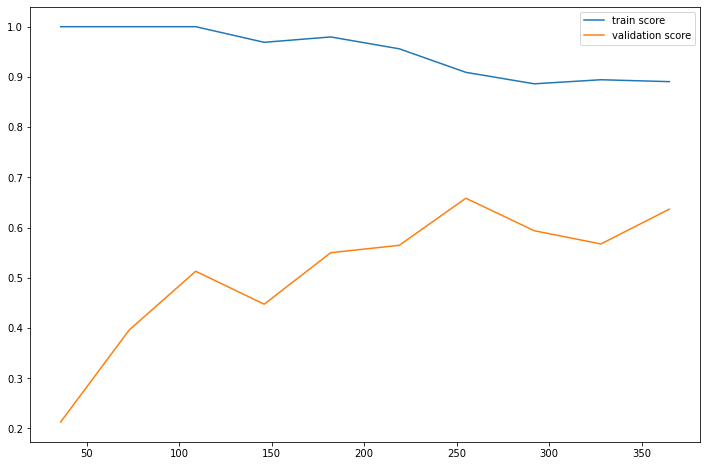

In [118]:
evaluation(grid.best_estimator_)

# Precision Recall Curve
fonction qui permet de visualiser la future précision du modéle en fonction du seuil de prédiction.

In [121]:
from sklearn.metrics import precision_recall_curve

In [122]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))

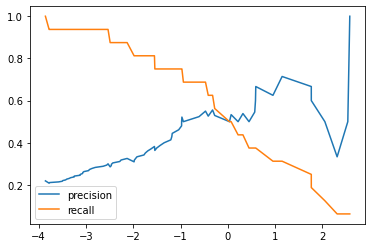

In [123]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [124]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

In [125]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-1)

In [126]:
from sklearn.metrics import recall_score

In [127]:
f1_score(y_test, y_pred)

0.5853658536585366

In [128]:
recall_score(y_test, y_pred)

0.75